In [1]:
from Bayesian_Neural_Network import bayesian_neural_network
from BNN_Learning_Rate_Tuning import bnn_learning_rate_tuning

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(10120024)

# Data Preparation

In [2]:
# load the dataset
df = pd.read_csv('fraud.csv', 
                    usecols=['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud'], 
                    nrows=2500)

# perform one-hot-eencoding on the column 'type'
dummies_df = pd.get_dummies(df['type'], dtype=int)

# concat the original data with the one-hot-encoded data
data = pd.concat((df, dummies_df), axis=1) \
            .drop(columns=['type'])

# perform min-max standarization
for col in data.columns:
    data[col] -= np.min(data[col]) 
    data[col] /= np.max(data[col])

data['isFraud'].replace(0, -1, inplace=True)

In [3]:
# percentage of fraud and non-fraud label in the data
data['isFraud'].value_counts().to_frame('percentage') / np.sum(data['isFraud'].value_counts()) * 100

,percentage
isFraud,
-1.0,99.36
1.0,0.64


In [4]:
# specify the feature and target data
feature_columns = data.columns[data.columns != 'isFraud']
target_columns = ['isFraud']

feature_data = data.loc[:, feature_columns]
target_data = data.loc[:, target_columns]

In [5]:
feature_data.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,0.002604,0.016840,0.015644,0.000000,0.0,0.0,0.0,0.0,1.0,0.0
1,0.000492,0.002103,0.001892,0.000000,0.0,0.0,0.0,0.0,1.0,0.0
2,0.000046,0.000018,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0
3,0.000046,0.000018,0.000000,0.001085,0.0,0.0,1.0,0.0,0.0,0.0
4,0.003088,0.004113,0.002917,0.000000,0.0,0.0,0.0,0.0,1.0,0.0


In [6]:
target_data.head()

,isFraud
0,-1.0
1,-1.0
2,1.0
3,1.0
4,-1.0


In [7]:
fraud_data = data.loc[data['isFraud'] == 1, :]
fraud_feature_data = fraud_data.loc[:, feature_columns].values
fraud_target_data = fraud_data.loc[:, target_columns].values 

non_fraud_data = data.loc[data['isFraud'] == -1, :]
non_fraud_feature_data = non_fraud_data.head(100).loc[:, feature_columns].values
non_fraud_target_data = non_fraud_data.head(100).loc[:, target_columns].values

feature_data = pd.concat((fraud_data.loc[:, feature_columns], non_fraud_data.head(25).loc[:, feature_columns])).values
target_data = pd.concat((fraud_data.loc[:, target_columns], non_fraud_data.head(25).loc[:, target_columns])).values

# Model Learning Rate Tuning

In [8]:
input_layer = [len(feature_columns)]
hidden_layers = [32, 16, 8, 4, 2]
output_layer = [1]

initial_lr_power = 20
end_lr_power = 24
total_iters = 4
tuning_epochs = 10

model_purpose = 'binary'

In [9]:
bnn_lr_tuning = bnn_learning_rate_tuning(input_layer, 
                                         hidden_layers, 
                                         output_layer, 
                                         feature_data, 
                                         target_data,
                                         model_purpose=model_purpose, 
                                         initial_lr_power=initial_lr_power, 
                                         end_lr_power=end_lr_power, 
                                         total_iters=total_iters, 
                                         tuning_epochs=tuning_epochs)

In [10]:
bnn_lr_tuning.perform_learning_rate_tuning()

------------------------------------------------------------------------------------------------------------------------------------------------------
Iter : 1 / 4 - Learning Rate : 1e-20 - Time Passed : 1.09 Second
Accuracy : 60.97560975609756% - Standard Deviation : 0.9484633570216404
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
Iter : 2 / 4 - Learning Rate : 1e-21 - Time Passed : 1.07 Second
Accuracy : 60.97560975609756% - Standard Deviation : 0.9322641615112686
------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------

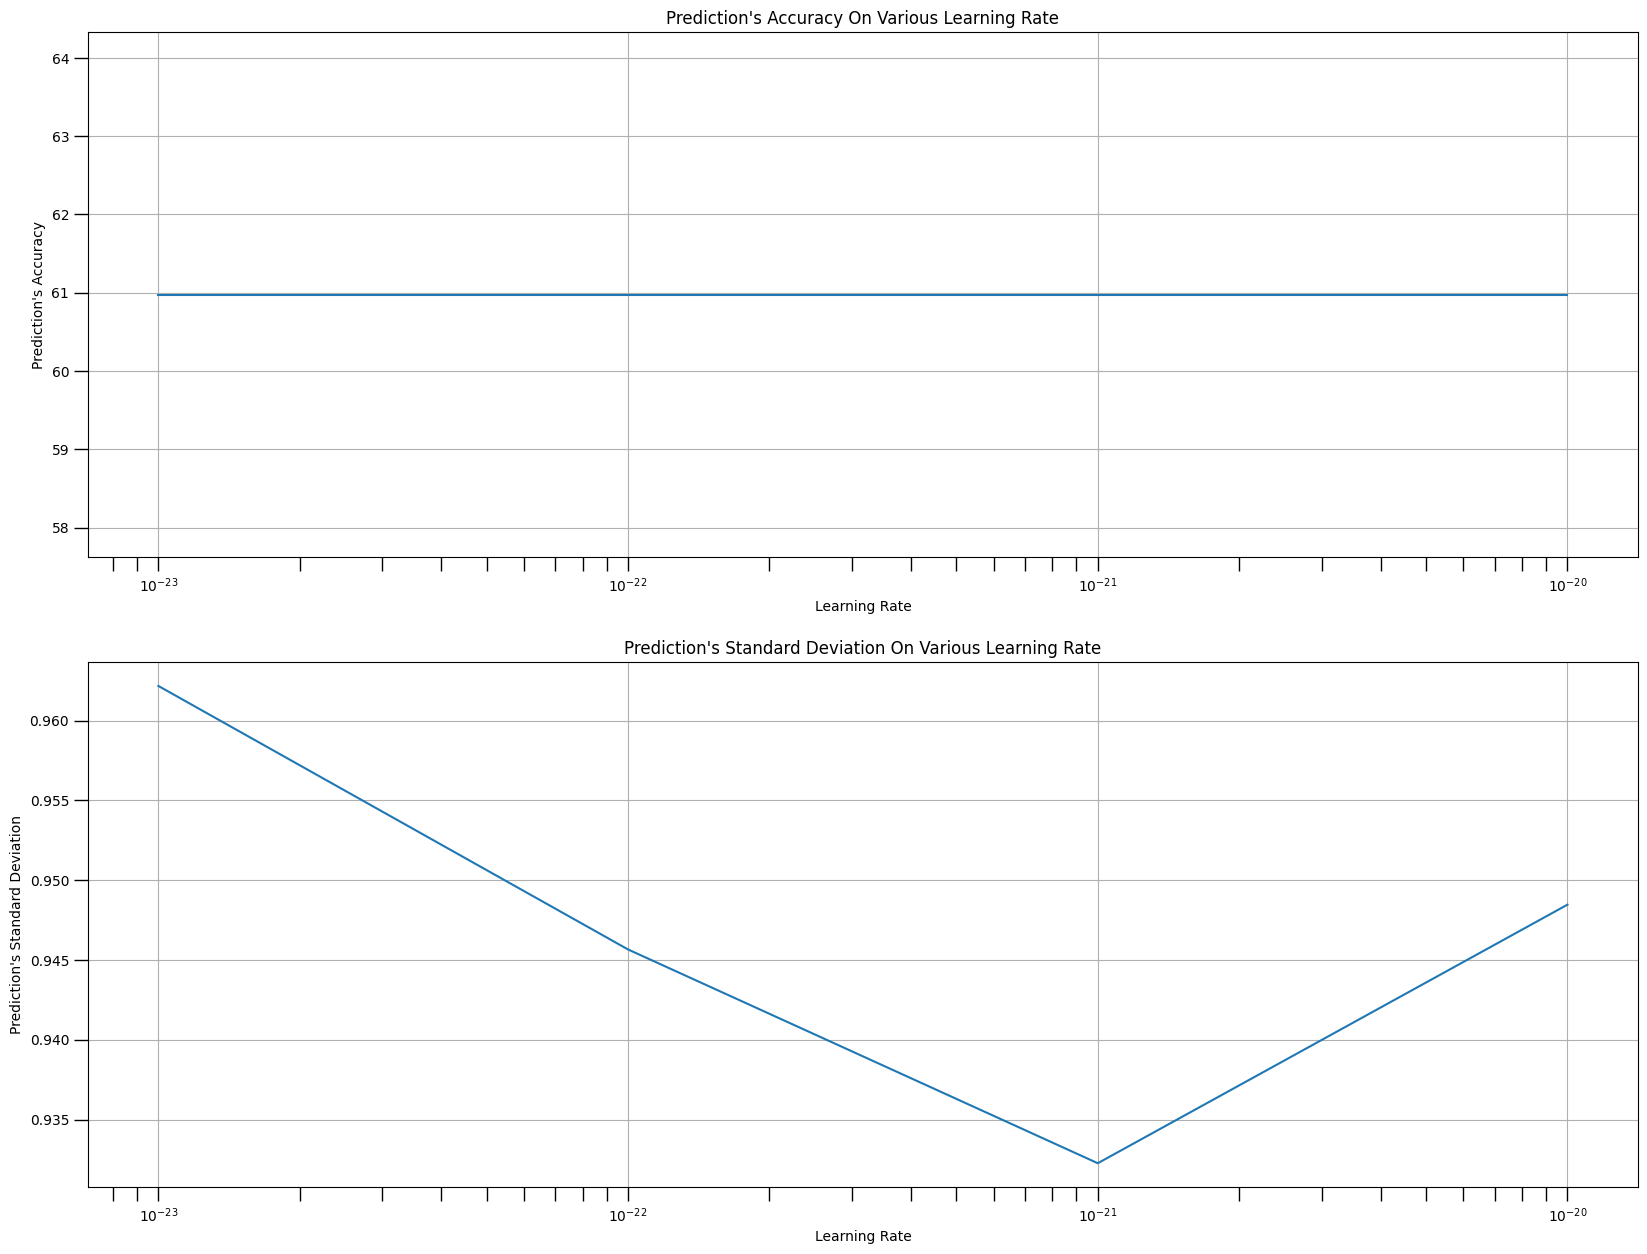

In [11]:
bnn_lr_tuning.visualize_learning_rate_tuning()

# Model Performance on Predicting Fraud Data (Labeled as 1)

In [12]:
input_layer = [len(feature_columns)]
hidden_layers = [32, 16, 8, 4, 2]
output_layer = [1]

total_epochs = 10
initial_lr = 1
end_lr = 5e-2
validation_percentage = 0.1

model_purpose = 'binary'
learning_rate_decay_type = 'exponential'

In [13]:
bnn = bayesian_neural_network(input_layer, 
                                hidden_layers, 
                                output_layer, 
                                feature_data, 
                                target_data, 
                                validation_percentage=validation_percentage, 
                                model_purpose='binary', 
                                initial_lr=initial_lr, 
                                end_lr=end_lr,
                                learning_rate_decay_type=learning_rate_decay_type,
                                total_epochs=total_epochs)

In [14]:
# model performance before training
bnn.bnn_fp.feed_forward_neural_network(bnn.m, bnn.v, bnn.feature_data, bnn.model_structure, model_purpose=bnn.model_purpose)[0]

array([-0.28 , -0.304, -0.28 , -0.304, -0.272, -0.304, -0.32 , -0.248,
       -0.288, -0.272, -0.304, -0.272, -0.304, -0.296, -0.272, -0.28 ,
       -0.304, -0.312, -0.312, -0.312, -0.304, -0.304, -0.312, -0.28 ,
       -0.28 , -0.312, -0.312, -0.312, -0.328, -0.288, -0.312, -0.312,
       -0.312, -0.288, -0.312, -0.28 ])

In [15]:
bnn.train_model()

------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch : 1 / 10 - Learning Rate : 0.5 - Succesfull Train Percentage : 100.0% - Time Passed : 0.16 Second
Accuracy : 55.55555555555556% - Standard Deviation : 0.9636634493811194
Validation Accuracy : 100.0% - Validation Standard Deviation : 0.9719247187830302
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch : 2 / 10 - Learning Rate : 0.25 - Succesfull Train Percentage : 100.0% - Time Passed : 0.16 Second
Accuracy : 55.55555555555556% - Standard Deviation : 0.9472530920487832
Validation Accuracy : 100.0% - Validation Standard Deviation : 0.9538399497802527
------------------------------

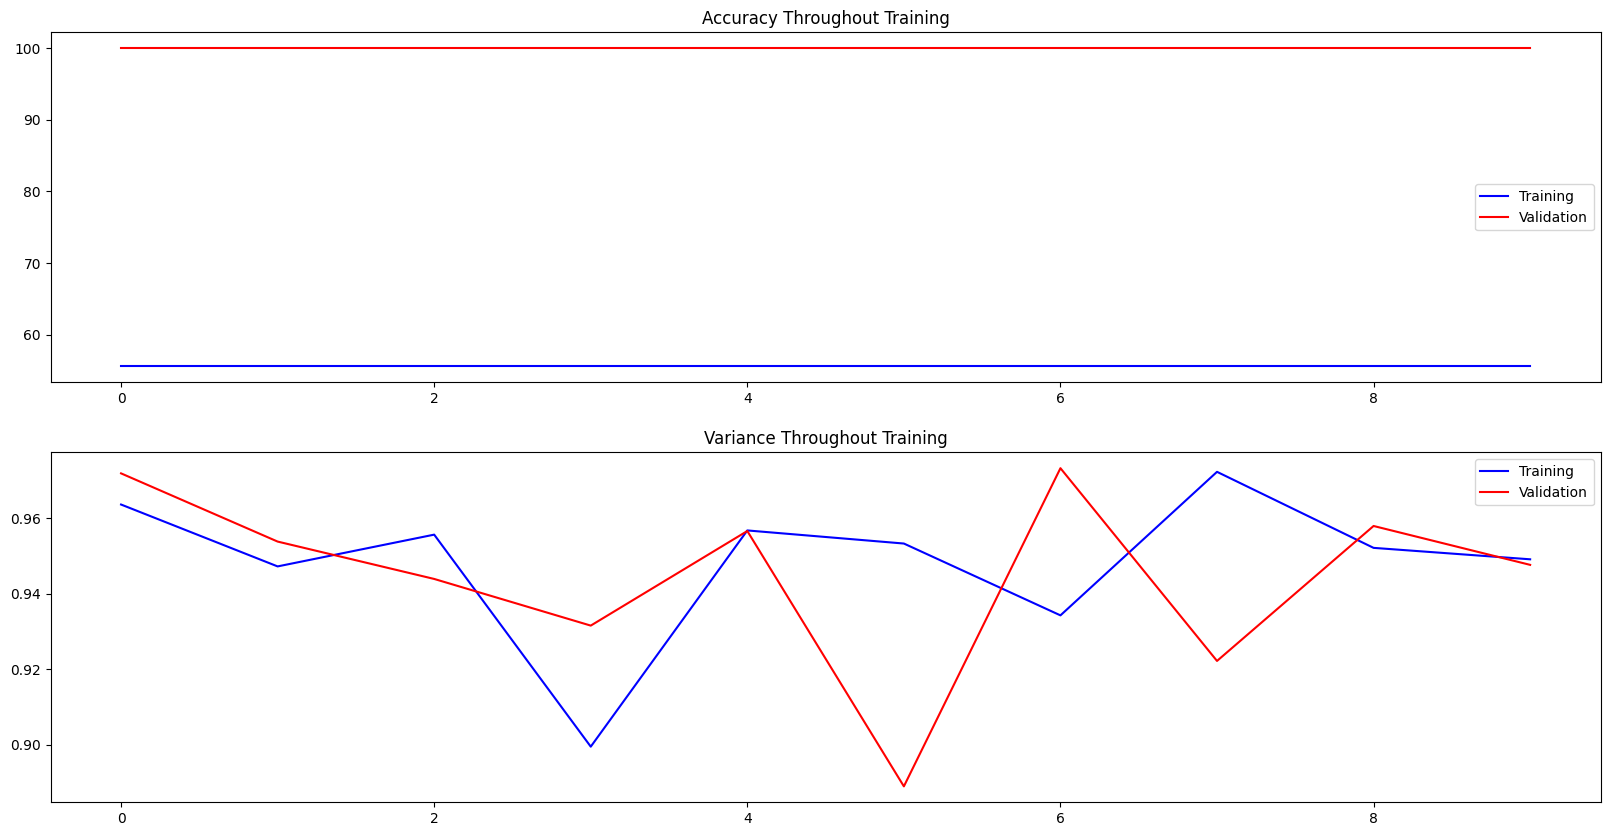

In [16]:
bnn.visualize_model_performance()

In [17]:
# model performance after training
bnn.bnn_fp.feed_forward_neural_network(bnn.m, bnn.v, bnn.feature_data, bnn.model_structure, model_purpose=bnn.model_purpose)[0]

array([-0.36 , -0.344, -0.36 , -0.344, -0.36 , -0.344, -0.352, -0.32 ,
       -0.32 , -0.36 , -0.344, -0.36 , -0.344, -0.336, -0.376, -0.328,
       -0.296, -0.296, -0.296, -0.304, -0.304, -0.296, -0.296, -0.352,
       -0.352, -0.296, -0.296, -0.296, -0.312, -0.328, -0.296, -0.296,
       -0.296, -0.368, -0.296, -0.344])

# Model Performance on Predicting Non-Fraud Data (Labeled With -1)

In [18]:
input_layer = [len(feature_columns)]
hidden_layers = [32, 16, 8, 4, 2]
output_layer = [1]

total_epochs = 25
initial_lr = 1
end_lr = 1e-2
validation_percentage = 0.1

model_purpose = 'binary'
learning_rate_decay_type = 'exponential'

In [19]:
bnn = bayesian_neural_network(input_layer, 
                                hidden_layers, 
                                output_layer, 
                                feature_data, 
                                target_data, 
                                validation_percentage=validation_percentage, 
                                model_purpose='binary', 
                                initial_lr=initial_lr, 
                                end_lr=end_lr,
                                learning_rate_decay_type=learning_rate_decay_type,
                                total_epochs=total_epochs)

In [20]:
# model performance before training
bnn.bnn_fp.feed_forward_neural_network(bnn.m, bnn.v, bnn.feature_data, bnn.model_structure, model_purpose=bnn.model_purpose)[0]

array([-0.288, -0.312, -0.288, -0.312, -0.288, -0.312, -0.336, -0.28 ,
       -0.296, -0.288, -0.312, -0.288, -0.312, -0.296, -0.264, -0.256,
       -0.312, -0.312, -0.312, -0.312, -0.304, -0.312, -0.312, -0.352,
       -0.36 , -0.312, -0.312, -0.312, -0.304, -0.288, -0.312, -0.312,
       -0.312, -0.264, -0.312, -0.352])

In [21]:
bnn.train_model()

------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch : 1 / 25 - Learning Rate : 0.25 - Succesfull Train Percentage : 100.0% - Time Passed : 0.16 Second
Accuracy : 55.55555555555556% - Standard Deviation : 0.9583126155301884
Validation Accuracy : 100.0% - Validation Standard Deviation : 0.971882656649138
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch : 2 / 25 - Learning Rate : 0.125 - Succesfull Train Percentage : 100.0% - Time Passed : 0.16 Second
Accuracy : 55.55555555555556% - Standard Deviation : 0.9463783770653647
Validation Accuracy : 100.0% - Validation Standard Deviation : 0.9747558089996256
-----------------------------

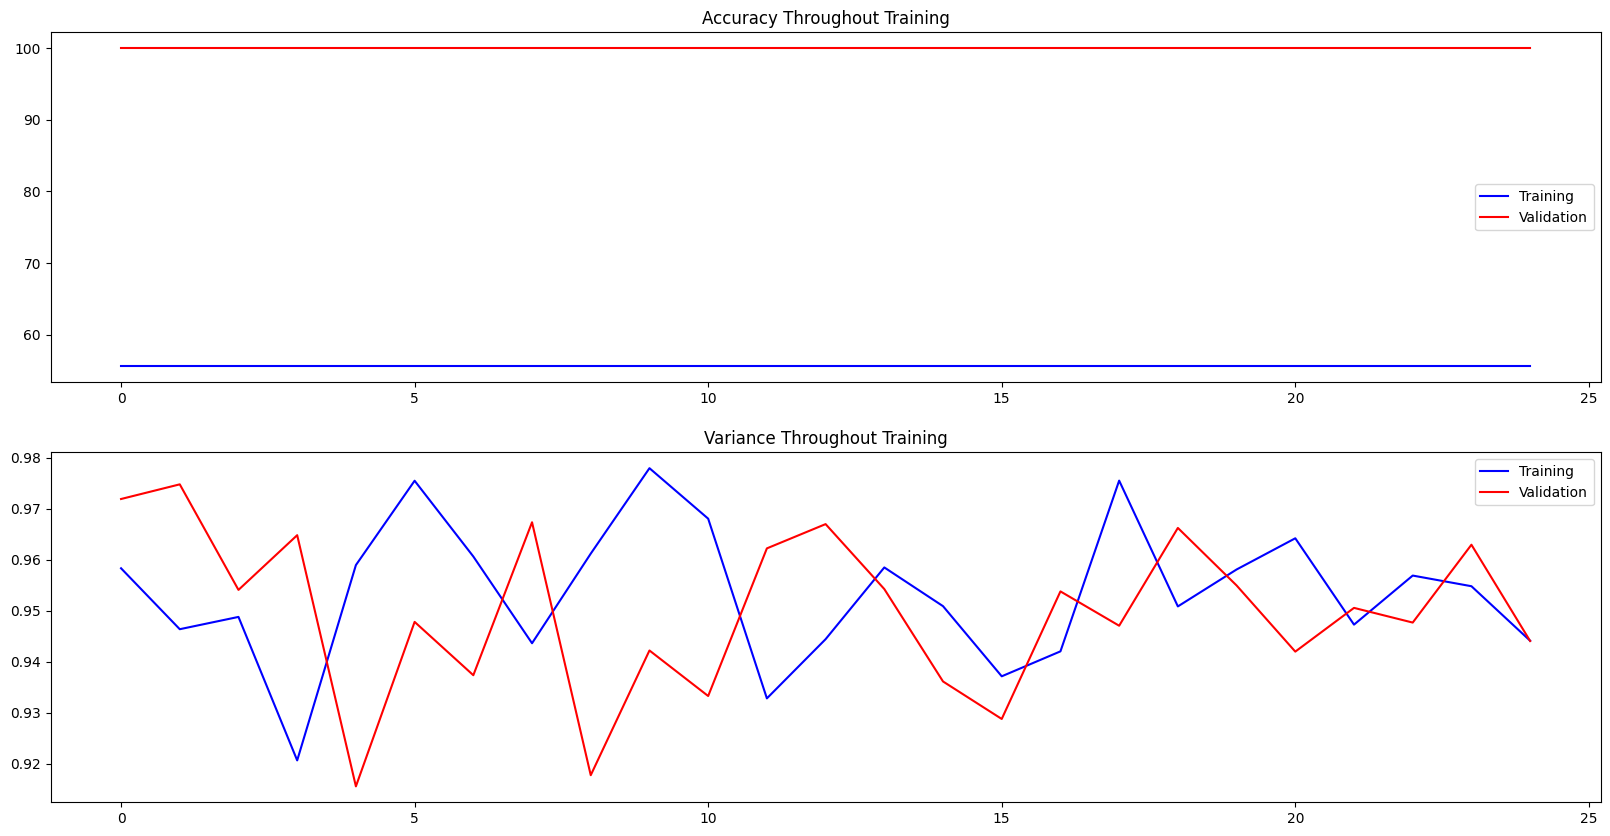

In [22]:
bnn.visualize_model_performance()

In [23]:
# model performance after training
bnn.bnn_fp.feed_forward_neural_network(bnn.m, bnn.v, bnn.feature_data, bnn.model_structure, model_purpose=bnn.model_purpose)[0]

array([-0.256, -0.272, -0.256, -0.272, -0.264, -0.272, -0.256, -0.24 ,
       -0.272, -0.264, -0.272, -0.264, -0.272, -0.28 , -0.24 , -0.288,
       -0.192, -0.192, -0.192, -0.192, -0.184, -0.184, -0.192, -0.224,
       -0.224, -0.192, -0.192, -0.192, -0.176, -0.288, -0.192, -0.192,
       -0.192, -0.256, -0.192, -0.224])

# Model Performance on Fraud and Non-Fraud Data

In [ ]:
input_layer = [len(feature_columns)]
hidden_layers = [32, 16, 8, 4, 2]
output_layer = [1]

total_epochs = 100
initial_lr = 1e-4
end_lr = 1e-8
# validation_percentage = 0.1

model_purpose = 'binary'
learning_rate_decay_type = 'exponential'

In [ ]:
bnn = bayesian_neural_network(input_layer, 
                              hidden_layers, 
                              output_layer, 
                              feature_data, 
                              target_data, 
                              validation_percentage=None,
                              model_purpose=model_purpose, 
                              initial_lr=initial_lr,
                              end_lr=end_lr)
bnn.standardize_dataset()
# bnn.generate_validation_training_dataset()
bnn.generate_m()
bnn.generate_v()

In [ ]:
# model performance on predicting fraudulent data before training
bnn.bnn_fp.feed_forward_neural_network(bnn.m, bnn.v, bnn.feature_data[bnn.target_data == 1], bnn.model_structure, model_purpose=bnn.model_purpose)[0]

In [ ]:
# model performance on predicting non-fraudulent data before training
bnn.bnn_fp.feed_forward_neural_network(bnn.m, bnn.v, bnn.feature_data[bnn.target_data == -1], bnn.model_structure, model_purpose=bnn.model_purpose)[0]

In [ ]:
bnn.train_model(total_epochs, learning_rate_decay_type)

In [ ]:
bnn.visualize_model_performance()

In [ ]:
# model performance on predicting fraudulent data before training
bnn.bnn_fp.feed_forward_neural_network(bnn.m, bnn.v, bnn.feature_data[bnn.target_data == 1], bnn.model_structure, model_purpose=bnn.model_purpose)[0]

In [ ]:
# model performance on predicting non-fraudulent data before training
bnn.bnn_fp.feed_forward_neural_network(bnn.m, bnn.v, bnn.feature_data[bnn.target_data == -1], bnn.model_structure, model_purpose=bnn.model_purpose)[0]

# Model Performance On The Data

In [ ]:
input_layer = [len(feature_columns)]
hidden_layers = [32, 16, 8, 4, 2]
output_layer = [1]

total_epochs = 100
initial_lr = 1e-30
end_lr = 1e-32
validation_percentage = 0.1

error_type = 'accuracy'
learning_rate_decay_type = 'exponential'

In [ ]:
bnn = bayesian_neural_network(input_layer, 
                              hidden_layers, 
                              output_layer, 
                              feature_data, 
                              target_data, 
                              validation_percentage=validation_percentage,
                              error_type=error_type, 
                              initial_lr=initial_lr,
                              end_lr=end_lr)
bnn.standardize_dataset()
bnn.generate_validation_training_dataset()
bnn.generate_m()
bnn.generate_v()

In [ ]:
bnn.train_model(total_epochs, learning_rate_decay_type)

In [ ]:
bnn.visualize_model_performance()